#::::: IMFORMATION CONTAGION MODEL SIMULATOR :::::
#
#   BASED ON : 
# "INFORMATION CONTAGION" by W.BRIAN ARTHUR and DAVID A. LANE
# Structural Change and Economic Dynamics, vol.4, no.1, 1993
# Lisence : GPL
# coder : smgw
#smgw@cc.musashi.ac.jp, Faculty of Economics, Musashi Univ. Tokyo Japan


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import random as rand
import os
import csv
from datetime import datetime

In [2]:
# parameters and random generators 

# default parameters for π_i, σ_i : purchasers' priors 
sigma_A = 1
sigma_B = 1
m_A = 10
m_B = 10

# true performance of the products 
c_star_A = 10
c_star_B = 9

#  purchasers' prior : π_i's are under normal distribution 
pi_A = lambda : np.random.normal(m_A,sigma_A**2)
pi_B = lambda : np.random.normal(m_B,sigma_B**2)

# σ_ob : obserbation ambiguity 
sigma_ob = 1

# tau, the stopping rule :  maximum num. of sampling for an agent
tau = 30
sample_num = lambda  : round(np.random.uniform(1,tau))

# Buyers' implession : 
X_A = lambda  : np.random.normal(0,sigma_ob**2) + c_star_A
X_B = lambda  : np.random.normal(0,sigma_ob**2) + c_star_B

# constant risk utility's parameter :  lambda
Lambda = 0.5

In [3]:
# market scale 
market_scl = 10000
# default number of agents who has got product A or B
default_num = 50

In [4]:
def sampling_index(m,n,r):
    # from integers 0 ... m, choose n indices 
    # r represents this sampling to be with/without replacement: r=1 ; replace, r=0 ; does not replace
    # output : 
    if r==1 :
        xx = np.round(np.random.uniform(0,m,n))
        zz = [int(i) for i in xx]
        return zz
    else:
        xx = set(np.round(np.random.uniform(0,m,n)))
        if len(xx)==n :
            zz = [int(i) for i in list(xx)]
            return zz
        else:
            return sampling_index(m,n,0)

# providing the index-lists for buyers of A/B
def i_AB(ind,ab) :
    tmpA = [] ; tmpB = []
    for j in range(len(ind)):
        if ab[j]==1 :
            #print(j)
            tmpA.append(ind[j])
        else:
            tmpB.append(ind[j])
    return tmpA,tmpB # tmpA : the indices of buyers who bought A, tmpB : o.w.

# giving the num. of perchasers for each product
# ab : sampled list in which 0 or 1 represents corresponding agents' purchase.
n_A = lambda ab : sum(ab)  
n_B = lambda ab : len(ab) - n_A(ab)

# mean values of utilities of sampled agents list from X for productA/B
Xtilde_A = lambda ia, X : sum([X[i] for i in ia])/len(ia) if len(ia) != 0 else X[0]
Xtilde_B = lambda ib, X : sum([X[i] for i in ib])/len(ib) if len(ib) != 0 else X[0]

In [5]:
def m_post_A(sigmaA,mA, jA,xx):
    # output:   mean val. of posterior for π_A
    # sigmaA : std dev. of prior π_A
    # mA : mean of prior π_A 
    # jA : sampled index list of agents  who've  already bought A
    nA=len(jA)
    XtA = Xtilde_A(jA,xx)
    tmp1 = sigmaA**2/(nA*sigmaA**2+sigma_ob**2)
    tmp2 = nA*XtA + (sigma_ob**2*mA)/sigmaA**2
    return tmp1*tmp2 

def m_post_B(sigmaB,mB, jB,xx):
    # output:   mean val. of posterior for π_B
    # sigmaB : std dev. of prior π_B
    # mB : mean of prior π_B
    # jB : sampled index list of agents  who've  already bought B
    nB=len(jB)
    XtB = Xtilde_B(jB,xx)
    tmp1 = sigmaB**2/(nB*sigmaB**2+sigma_ob**2)
    tmp2 = nB*XtB + (sigma_ob**2*mB)/sigmaB**2
    return tmp1*tmp2 

def sigma_post_A(sigmaA,mA,jA):
    # output : deviation of posterior for π_A
    # sigmaA, mA, jA 's are all similar to m_post_A().
    nA=len(jA)
    tmp1=sigma_ob**2*sigmaA**2
    tmp2=nA*sigmaA**2+sigma_ob**2
    return np.sqrt(tmp1/tmp2)

def sigma_post_B(sigmaB,mB,jB):
    # output : deviation of posterior for π_B
    # sigmaB, mB, jB 's are all similar to m_post_B().
    nB=len(jB)
    tmp1=sigma_ob**2*sigmaB**2
    tmp2=nB*sigmaB**2+sigma_ob**2
    return np.sqrt(tmp1/tmp2)

# the utility function: A, B's are just tags for human-readability 
# mu and sigma are those which are outputs of m_post_i and sigma_post_i respectively 
U_A = lambda mu,sgma : mu - Lambda * sgma**2
U_B = lambda mu,sgma : mu - Lambda * sgma**2

In [6]:
# --------------- for SC model : parameter α and e ---------
Alpha = lambda s :  1/(s**2) # < - s is a standard deviation 
E = lambda c,s,m : Alpha(s)*(c-m) # < - c: true performance, s:std dev., m: mean

# ---------------------------------------------------------------

In [16]:
# SO HERE WE GO : LET'S BEGIN

def do_experiment2(sa,sb,ma,mb,rrr, u) : 
    # arguments are the default parameters of pi_A, pi_B. r = 0 or 1 (replace or not), 
    # u: parameters update or not. 0, not update, 1, update
    # initialization 
    sigma_A = sa
    sigma_B = sb
    m_A = ma
    m_B = mb
    r = rrr # replace or not replace ?  1: replace, 0:not replace 
    # place to save data(graphs) for the initial param.s above 
    #param = str(sigma_A)+'_'+ str(sigma_B)+'_'+ str(m_A)+'_'+ str(m_B)+'_'+str(r)+'_'+str(u)+ '/'
    param = str(c_star_A)+'_'+str(c_star_B)+'_'+str(sigma_ob)+'_'+str(sigma_A)+'_'+ str(sigma_B)+'_'+ str(m_A)+'_'+ str(m_B)+'_'+str(r)+'_'+str(tau)+'_'+str(u)+ '/'
    # afterwards these lists will be fullfilled till the whole market scale
    a_or_b = np.array([ np.random.binomial(1,1/2) for i in range(default_num)])
    X = np.array([ (a_or_b[i])*X_A() + (1-a_or_b[i])*X_B() for i in range(default_num)])

    #print(a_or_b)
    counter = default_num+1

    # market_scl = 
    while counter < market_scl :
        aa = sampling_index(len(a_or_b)-1,sample_num(),r)   #  
        b = [a_or_b[i] for i in aa] # sampled buyers' tagging : 1 or 0 ( A or B )
        iA,iB = i_AB(aa,b)  # indices for buyers A , B  respectively
        MuPostA = m_post_A(sigma_A,m_A,iA,X)
        SigmaPostA = sigma_post_A(sigma_A,m_A,iA)
        MuPostB = m_post_B(sigma_B,m_B,iB,X)
        SigmaPostB = sigma_post_B(sigma_B,m_B,iB)
        if U_A(MuPostA,SigmaPostA) >= U_B(MuPostB,SigmaPostB) :
            tmp1=np.append(a_or_b,[1]) # appending the decision ( buying A )
            tmp2=np.append(X,[X_A()]) # appending impression of A 
            a_or_b = tmp1
            X = tmp2
            #print('A')
        else :
            tmp1=np.append(a_or_b,[0])
            tmp2=np.append(X,[X_B()])
            a_or_b = tmp1
            X = tmp2
            #print('B')
        if u==1:
            m_A = MuPostA
            sigma_A = SigmaPostA
            m_B = MuPostB
            sigma_B = SigmaPostB
        
        counter = counter +1

    accum_a_or_b_A = np.array([sum(a_or_b[0:i])/(i+1) for i in range(len(a_or_b))])
    #accum_a_or_b_B = np.array([1-sum(a_or_b[0:i])/(i+1) for i in range(len(a_or_b))])
    accum_a_or_b_B = np.array([1-accum_a_or_b_A[i] for i in range(len(a_or_b))])
    df_accum_a_or_b = pd.DataFrame([accum_a_or_b_A,accum_a_or_b_B])
    return (sigma_A,sigma_B,m_A,m_B,r,param,df_accum_a_or_b)
    #          0        1    2   3  4   5           6

In [19]:
csvfile = open("parameters.csv", "r")
par1 = list(csv.reader(csvfile, delimiter=","))
csvfile.close()

par1_v=[] 
for j in range(1,len(par1)):
    tmp=[]
    if par1[j][0] == '0' :
        continue
    for i in range(len(par1[j])-1):
        tmp.append(float(par1[j][i]))
    par1_v.append(tmp)

In [20]:
par1_v

[[10.0, 10.0, 6.0, 0.5, 0.5, 10.0, 10.0, 1.0, 10.0, 0.15]]

----
0.15
----
0:00:04.140426
0:00:04.095897
0:00:04.092852
0:00:04.128197
0:00:04.138300


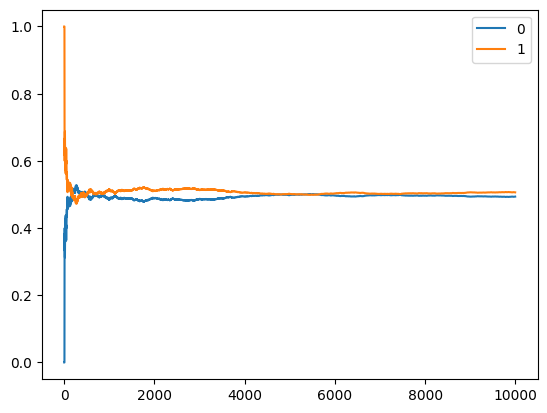

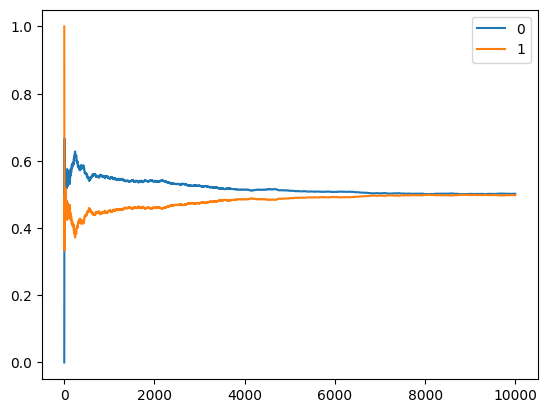

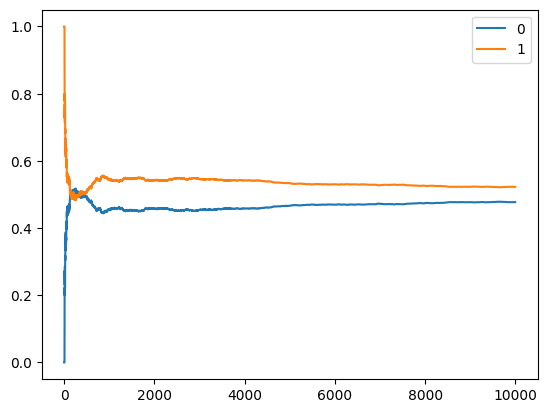

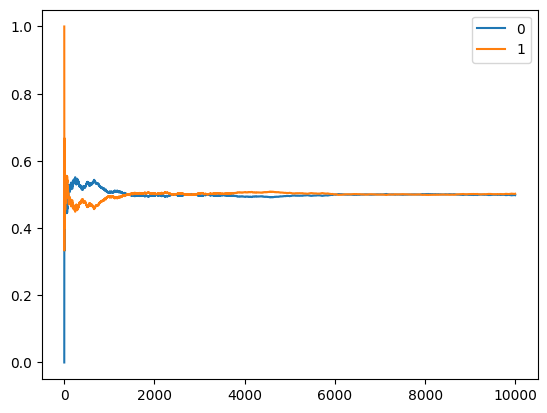

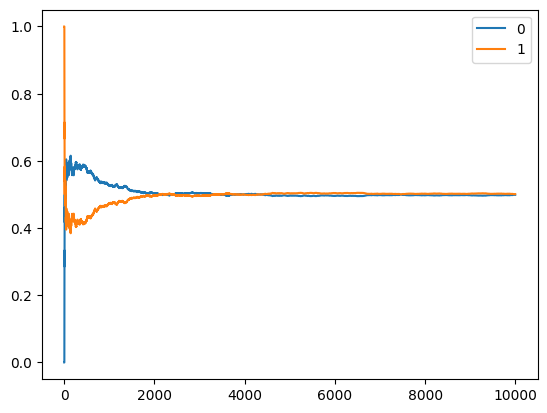

In [21]:
# --------------------- DO_EXPERIMENT (cvs file import is mandatory ! )-----------------
# the name of parameters' object : par1
## 
for ii in range(len(par1_v)):
#    if par1_v[ii][0]==0:
#        continue
    c_star = par1_v[ii][0]
    c_star_A = par1_v[ii][0]
    c_star_B = par1_v[ii][1]
    # σ_ob : obserbation ambiguity 
    sigma_ob = par1_v[ii][2]
    Sigma = par1_v[ii][3] ; Mu = par1_v[ii][5]
    sA = par1_v[ii][3] 
    sB = par1_v[ii][4] 
    mA = par1_v[ii][5] 
    mB = par1_v[ii][6] 
    rr = par1_v[ii][7] 
    tau = par1_v[ii][8] 
    Lambda = par1_v[ii][9]
    C = 5 # number of the experiments to execute for the parameters above  

    # check if Lambda - e > 0
    # E = lambda c,s,m : Alpha(s)*(c-m) # < - c: true performance, s:std dev., m: mean
    print('----')
    print(Lambda + E(c_star,Sigma,Mu))
    print('----')

    for i in range(C):
        start=datetime.now()
        results = do_experiment2(sA,sB,mA,mB,rr,0)
        print(datetime.now()-start)
        d = start.strftime('%Y%m%d%H%M%S')
        if os.path.exists(results[5])==False:
            os.mkdir(results[5])
        tmp3=results[6].transpose()
        graph_path = results[5] + d + '.pdf'
        data_path = results[5] + d + '.csv'
        file = tmp3.plot().get_figure()
        file.savefig(graph_path)
        results[6].to_csv(data_path)
        #    print('sigma_A=' + str(results[0])) ;  print('sigma_B=' + str(results[1]))
        #    print('m_A=' + str(results[2])) ;  print('m_B=' + str(results[3]))
        #    print(' - - - ') ;

In [ ]:
# for SC model
c_star = 10
c_star_A = c_star 
c_star_B = c_star

# σ_ob : obserbation ambiguity 
sigma_ob = 1

# for SC model :
Sigma = 0.5 ; Mu = 10.1
sA = Sigma
sB = Sigma
mA = Mu
mB = Mu
rr = 0
tau = 5

Lambda = 0.2

In [ ]:
# --------------------- DO_EXPERIMENT (2)  -----------------
# 
# true performance of the products 
c_star_A = 10
c_star_B = 9
# σ_ob : obserbation ambiguity 
sigma_ob = 1


C = 5 # number of the experiments to execute for the parameters above 

sA = 1
sB = 3
mA = 10
mB = 10
rr = 0
tau = 5


for i in range(C):
    start=datetime.now()
    results = do_experiment(sA,sB,mA,mB,rr)
    print(datetime.now()-start)
    #print(results)

    d = start.strftime('%Y%m%d%H%M%S')
    # print(d)
    if os.path.exists(results[5])==False:
        os.mkdir(results[5])
    tmp3=results[6].transpose()
    graph_path = results[5] + d + '.pdf'
    data_path = results[5] + d + '.csv'
    file = tmp3.plot().get_figure()
    file.savefig(graph_path)
    results[6].to_csv(data_path)

0:00:04.074991


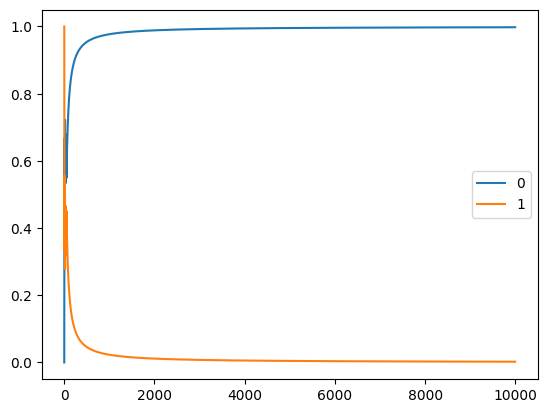

In [19]:
# ------ for one shot only -----

sA = 1
sB = 1
mA = 10
mB = 10
rr = 1

start=datetime.now()
results = do_experiment(sA,sB,mA,mB,rr)
print(datetime.now()-start)
#print(results)

d = start.strftime('%Y%m%d%H%M%S')
# print(d)
if os.path.exists(results[5])==False:
    os.mkdir(results[5])
tmp3=results[6].transpose()
graph_path = results[5] + d + '.pdf'
data_path = results[5] + d + '.csv'
file = tmp3.plot().get_figure()
file.savefig(graph_path)
results[6].to_csv(data_path)

In [14]:
results[6].transpose()

,0,1
0,0.000000,1.000000
1,0.500000,0.500000
2,0.333333,0.666667
3,0.250000,0.750000
4,0.400000,0.600000
...,...,...
9994,0.002601,0.997399
9995,0.002601,0.997399
9996,0.002601,0.997399
9997,0.002601,0.997399


In [16]:
#print(m_A) ; print(m_B)
print(MuPostA); print(MuPostB)

NameError: name 'MuPostA' is not defined